# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms
import matplotlib.patches as mpatches
import seaborn as sn
import time
import copy
import pulp
import requests

# Read datasets

In [ ]:
data_CDs = pd.read_excel('/content/drive/MyDrive/Unicamp/Pesquisa Operacional 1/Projeto Pesquisa Operacional 1/Magalu/CDs Matriz de dados Magalu.xlsx', sheet_name=0)
data_clientes = pd.read_excel('/content/drive/MyDrive/Unicamp/Pesquisa Operacional 1/Projeto Pesquisa Operacional 1/Magalu/Clientes Matriz de dados Magalu.xlsx', sheet_name=0)

data_CDs = data_CDs.drop(columns=['LATITUDE, LONGITUDE                                   ORIGENS'])
data_clientes = data_clientes.drop(columns=['LATITUDE, LONGITUDE                                   '])

#Dataframe with all cities (deposits + clients)
df = data_clientes
df = df.rename(columns={'CLIENTES': 'CIDADES'})
df.loc[15] = [15,data_CDs.iloc[0,1],data_CDs.iloc[0,2],data_CDs.iloc[0,3]]
df.loc[16] = [16,data_CDs.iloc[1,1],data_CDs.iloc[1,2],data_CDs.iloc[1,3]]

## Defining the initial conditions of the problem

In [ ]:
# Number of destinations (N)
customer_count = len(data_clientes)
print('Number of destinations :', customer_count)

# Number of deposits (M)
num_depots = len(data_CDs)
print('Number of deposits :', num_depots)

# Number of cities (N+ M)
num_cities = customer_count + num_depots
print('Total number of cities :', num_cities)
print('')

# Vehicle capacity (Considering a homogeneous fleet)
vehicle_capacity = 20
print('Vehicle capacity :', vehicle_capacity)

#Adding customer demand
data_clientes['DEMANDA']  = [2,2,2,3,1,3,1,1,2,3,2,2,3,2,3]
print('Customer demand :')
print('')
print(data_clientes['DEMANDA'])

print('')
print('Note: The number of vehicles will be tested for more than one value, and will be described throughout the code.')

Número de destinos : 15
Número de depósitos : 2
Número total de cidades : 17

Capacidade dos veículos : 20
Demanda dos clientes :

0     2
1     2
2     2
3     3
4     1
5     3
6     1
7     1
8     2
9     3
10    2
11    2
12    3
13    2
14    3
Name: DEMANDA, dtype: int64

Observação : O número de veículos será testado para mais de um valor, e estará descrito ao decorrer do código


## Defining the distance matrix using API

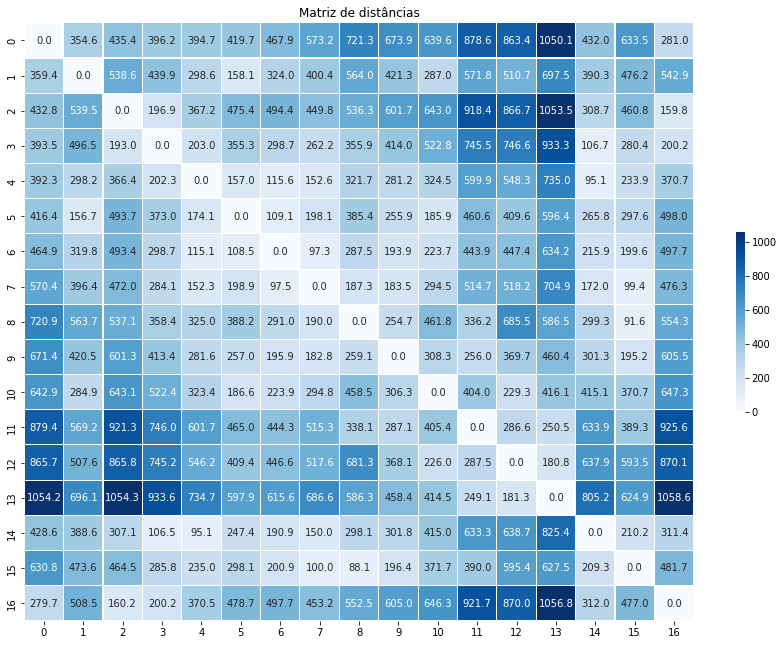

In [ ]:
bingMapsKey = "Ao9sYU7tUpDJ5RxqQHMkIODgEhdDM0a0qMGFWGrmcLq4FSIDo1cm3KITFkgRsLxZ"

distanceMatrix = []
for i in df.CIDADES:
  listCD = []
  for j in df.CIDADES:
    origin = i
    destination = j
    route = "http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=" + origin  + "&wp.1=" + destination + "/&key="+ bingMapsKey
    r = requests.get(url = route)
    result = r.json()
    distance = result["resourceSets"][0]["resources"][0]["travelDistance"]
    listCD.append(distance)
  distanceMatrix.append(listCD)

matrix = pd.DataFrame(distanceMatrix)

#Distance matrix plot
fig, ax = plt.subplots(figsize=(15, 11))
sn.heatmap(matrix, ax=ax, cmap='Blues', annot=True, fmt='.1f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('Distance matrix')
plt.show()

## Plotting the locations

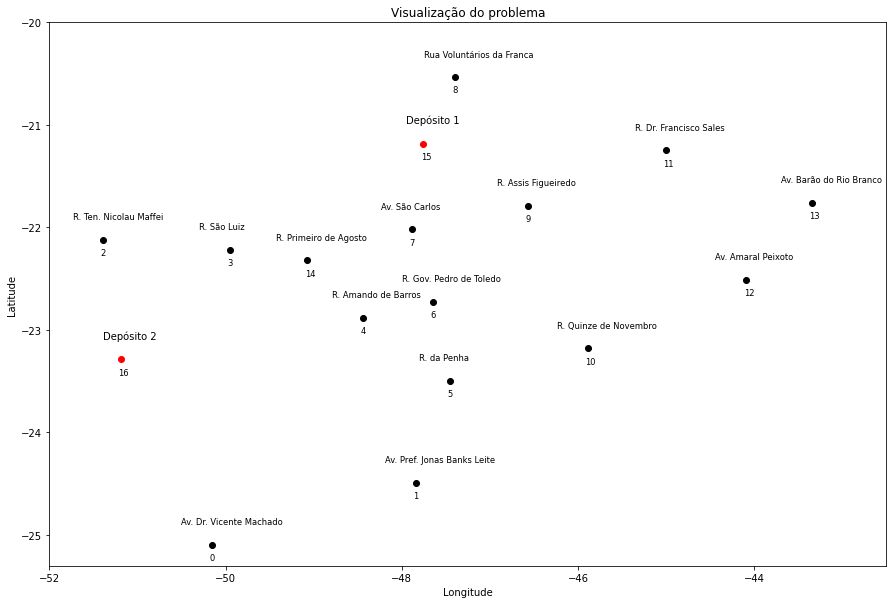

In [ ]:
lista1 = []
for i in df['CIDADES']:
  lista1.append(i.split(",")[0])
lista1

df['cidades abreviadas'] = lista1

def plot_fig(loc,heading="plot"):
    plt.figure(figsize=(15,10))
    plt.subplot(111)
    for i,row in loc.iterrows():
        if i==15:
            plt.scatter(row["x"],row["y"] ,c='r')
            plt.text(row["x"]-0.2, row["y"]+0.2 , 'Depósito 1 ')
            plt.text(row["x"] - 0.03, row["y"] - 0.15 ,full_data.loc[i]['ID'],fontsize ='small' )
        elif i ==16:
          plt.scatter(row["x"],row["y"] ,c='r')
          plt.text(row["x"]-0.2, row["y"]+0.2 , 'Depósito 2 ')
          plt.text(row["x"] - 0.03, row["y"] - 0.15  ,full_data.loc[i]['ID'],fontsize ='small' )
        else:
            plt.scatter(row["x"], row["y"] , c='black')
            plt.text(row["x"] - 0.35, row["y"] + 0.2 ,full_data.loc[i]['cidades abreviadas'],fontsize ='small')
            plt.text(row["x"] - 0.03, row["y"] - 0.15 ,full_data.loc[i]['ID'],fontsize ='small' )
        plt.xlim(-52,-42.5)
        plt.ylim(-25.3,-20)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(heading)

df = df.rename(columns={'LATITUDE': 'y','LONGITUDE': 'x'})

full_data=df.iloc[0:num_cities,:]
d=full_data[['x','y']]

plot_fig(d,heading="problem visualization")
plt.show()

## Example of a solution without breaking sub-routes

Número de veículos =  4
-----------------
Optimal | FO: 3236.7110000000007
-----------------

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 14)
(4, 6)
(5, 10)
(6, 4)
(7, 15)
(8, 15)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(15, 8)
(16, 0)
(16, 2)


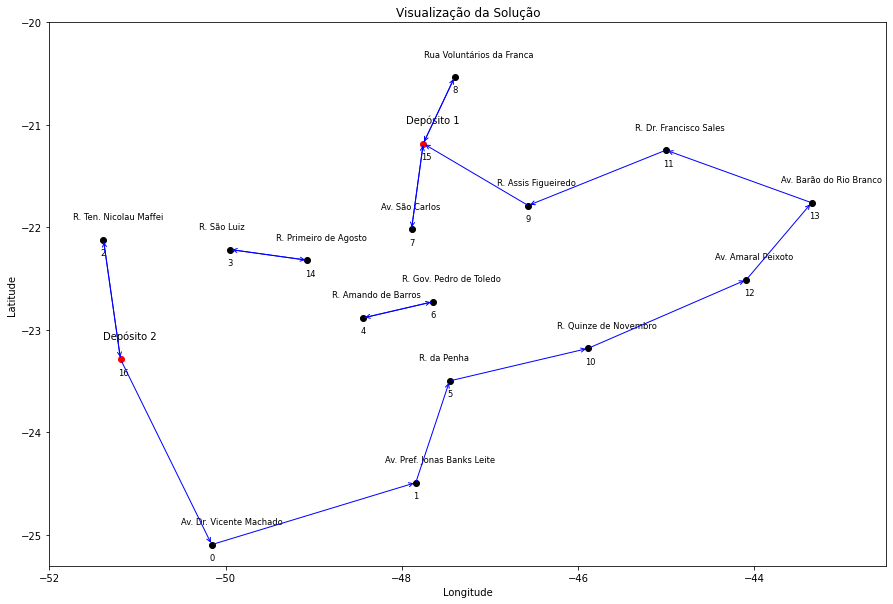

In [ ]:

#defining the problem
model=pulp.LpProblem('MDVRP',pulp.LpMinimize)


# generate all the variables, and then zero out what is needed
x=pulp.LpVariable.dicts("x",((i,j) for i in range(num_cities) for j in range(num_cities)),\
                            cat='Binary')

#Objective function
model+=pulp.lpSum(matrix[i][j]*x[i,j] for i in range(num_cities) \
                      for j in range(num_cities))

##Restrictions

#can't go from one city to another
for i in range(num_cities):
    model+=x[i,i]==0

#can't go from one warehouse to another
model+=x[15,16]==0
model+=x[16,15]==0

# (2) and (3)
for i in range(customer_count):
    model+=pulp.lpSum(x[i,j]  for j in range(num_cities))==1

for j in range(customer_count):
  model += pulp.lpSum(x[i,j]  for i in range(num_cities))==1

# (4) and (5)
model+=pulp.lpSum(x[i,j] for i in range(customer_count , num_cities) for j in range(num_cities))== 4

model+=pulp.lpSum(x[i,j] for j in range(customer_count , num_cities) for i in range(num_cities))== 4
print('Number of vehicles = ', 4)
status=model.solve()
print("-----------------")
print(pulp.LpStatus[status],'|','FO:',pulp.value(model.objective))

print("-----------------")
route=[(i,j) for i in range(num_cities) for j in range(num_cities) if pulp.value(x[i,j])==1]

print('')

print('Solution:')
for i in range(len(route)):
  print(route[i])

plot_fig(d,heading="Solution Visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in route:
    plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                      xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                     arrowprops=arrowprops)

## **Elimination of sub-routes using MTZ**

Considering vehicle capacity and customer demand


-----------------
Para 2 veículos :
-----------------
Optimal | FO: 3190.0700000000006 | Tempo computacional gasto: 4.4761 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 2)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 8)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(16, 0)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 2), (2, 16)]]


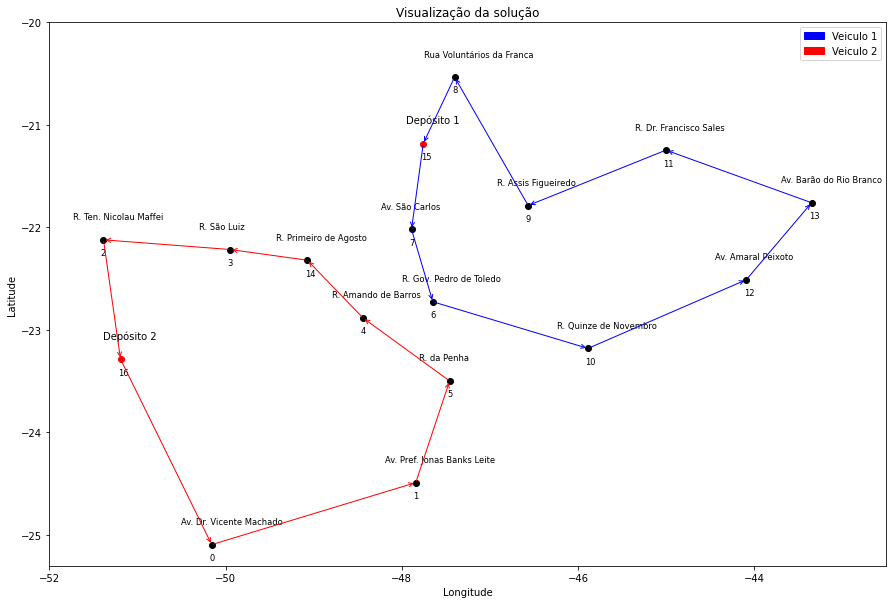


-----------------
Para 3 veículos :
-----------------
Optimal | FO: 3223.344000000001 | Tempo computacional gasto: 2.5002 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 2)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(15, 8)
(16, 0)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 15)], [(15, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 2), (2, 16)]]


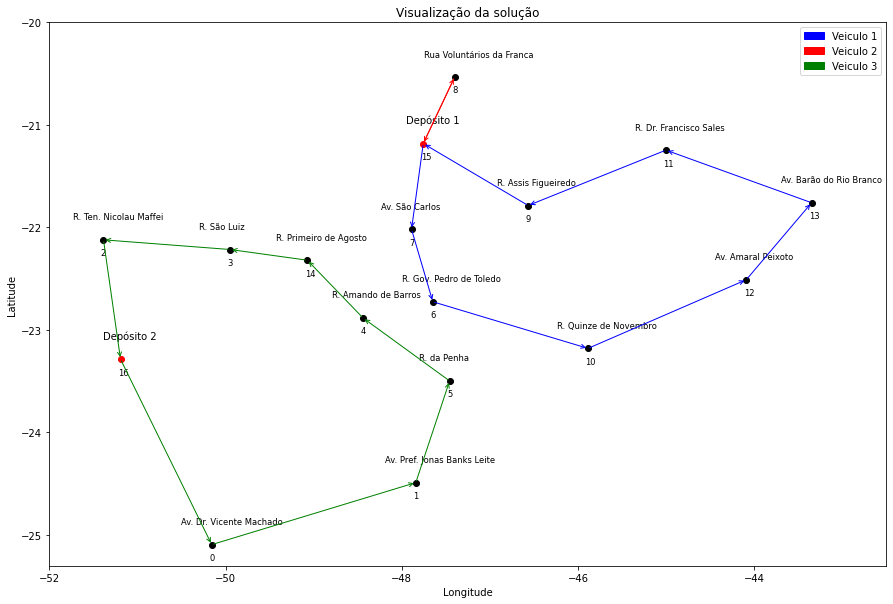


-----------------
Para 4 veículos :
-----------------
Optimal | FO: 3386.440000000001 | Tempo computacional gasto: 2.9538 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 16)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(15, 8)
(16, 0)
(16, 2)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 15)], [(15, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 16)], [(16, 2), (2, 16)]]


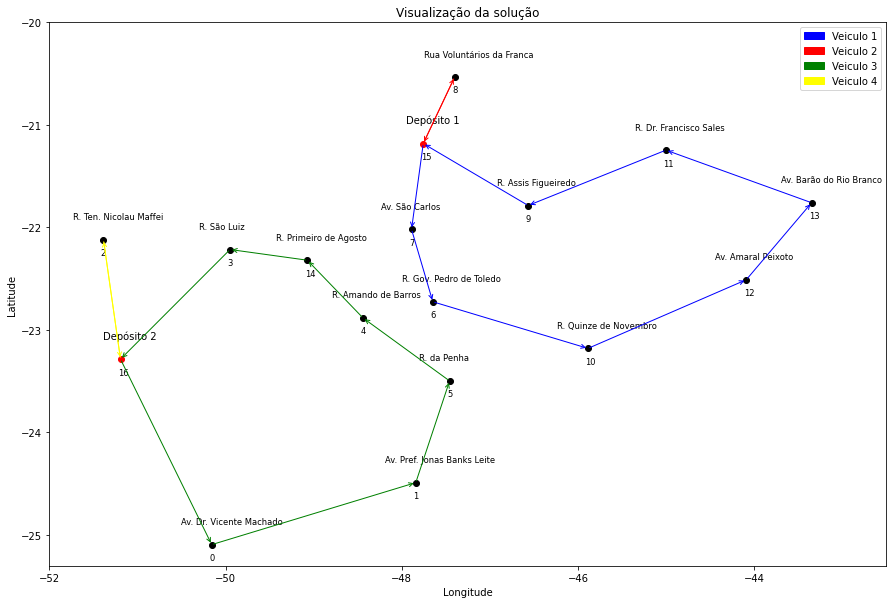

In [ ]:
numero_veiculos = [2,3,4]
for veiculos in numero_veiculos:

  start_t=time.time()
  print('')
  print("-----------------")
  print('For {} vehicles :'.format(veiculos))

  model=pulp.LpProblem('MDVRP',pulp.LpMinimize)

  #Variables
  x=pulp.LpVariable.dicts("x",((i,j) for i in range(num_cities) \
                             for j in range(num_cities)),\
                            cat='Binary')

  #Objective function
  model+=pulp.lpSum(matrix[i][j]*x[i,j] for i in range(num_cities) \
                      for j in range(num_cities))

  ## Restrictions
  
  #cannot move from one city to another
  for i in range(num_cities):
    model+=x[i,i]==0

  #can't go from one warehouse to another
  model+=x[15,16]==0
  model+=x[16,15]==0

  # (2) and (3)
  for i in range(customer_count):
    model+=pulp.lpSum(x[i,j] for j in range(num_cities))==1

  for j in range(customer_count):
    model += pulp.lpSum(x[i,j] for i in range(num_cities)) == 1

  # (4) and (5)
  model+=pulp.lpSum(x[i,j] for i in range(customer_count , num_cities) for j in range(num_cities))==veiculos

  model+=pulp.lpSum(x[i,j] for j in range(customer_count , num_cities) for i in range(num_cities))==veiculos

  ##Clear sub-routes
  
  #MTZ variables

  u = pulp.LpVariable.dicts("u", (i for i in range(customer_count)), \
                             lowBound=1,upBound= customer_count,cat='Integer')

  for i in range(customer_count):
    for j in range(customer_count):
      if i!=j:
        model+= u[i]-u[j]+(vehicle_capacity)*(x[i,j])<=vehicle_capacity - data_clientes['DEMANDA'][i]


  status=model.solve()
  print("-----------------")
  print(pulp.LpStatus[status],'|','FO:',pulp.value(model.objective),'|','Computational time spent:',np.round(time.time()-start_t,4),'s')

  route=[(i,j) for i in range(num_cities) \
            for j in range(num_cities) if pulp.value(x[i,j])==1]
  print('')

  print('Solution:')
  for i in range(len(route)):
    print(route[i])

  r=copy.copy(route)

  sequencia= []
  for i,j in r:
    if i==15 or i==16:
      sequencia.append([(i,j)])

  for a in sequencia:
    for i,j in r:
      if i == a[0][1]:
       a.append((i,j))

  for k in range(1,6):
    for a in sequencia:
      for i,j in r:
        if (a[1][1] != 15)&(a[1][1] != 16):
          if i == a[k][1] :
            a.append((i,j))

  for a in sequencia:
    for i,j in r:
      if (a[1][1] != 15)&(a[1][1] != 16) and (a[6][1] != 15)&(a[6][1] != 16):
        if i == a[6][1] :
          a.append((i,j))

  if veiculos == 2:
    for a in sequencia:
      for i,j in r:
        if (a[1][1] != 15)&(a[1][1] != 16) and (a[7][1] != 15)&(a[7][1] != 16):
          if i == a[7][1] :
            a.append((i,j))

  print('')
  print('Routes:')
  print(sequencia)
  plot_fig(d,heading="Visualizing the solution")

  lista_cores = ['blue', 'red', 'green', 'yellow']
  patch1 = mpatches.Patch(color='blue', label='Vehicle 1')
  patch2 = mpatches.Patch(color='red', label='VVehicle 2')
  patch3 = mpatches.Patch(color='green', label='Vehicle 3')
  patch4 = mpatches.Patch(color='yellow', label='Vehicle 4')
  lista_patchs = [patch1, patch2, patch3, patch4]

  lista3 = []
  lista4 = []
  for c in range(veiculos):
    lista3.append(lista_cores[c])
    lista4.append(lista_patchs[c])

  plt.legend(handles=lista4)

  for cor in range(len(lista3)):
    for i, j in sequencia[cor]:
      plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                    xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3', edgecolor=lista3[cor]))
  plt.show()

Considering the maximum number of destinations each vehicle can visit

-----------------
Número de veículos = 5
Cada veículo pode visitar no máximo 3 destinos (L = 3)
-----------------

-----------------
Optimal | FO: 4592.503 | Tempo computacional gasto: 38.0737 s

Soluçao:
(0, 16)
(1, 0)
(2, 3)
(3, 14)
(4, 6)
(5, 1)
(6, 7)
(7, 15)
(8, 11)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 15)
(14, 15)
(15, 4)
(15, 5)
(15, 8)
(15, 10)
(16, 2)

Rotas:
[[(15, 4), (4, 6), (6, 7), (7, 15)], [(15, 5), (5, 1), (1, 0), (0, 16)], [(15, 8), (8, 11), (11, 9), (9, 15)], [(15, 10), (10, 12), (12, 13), (13, 15)], [(16, 2), (2, 3), (3, 14), (14, 15)]]


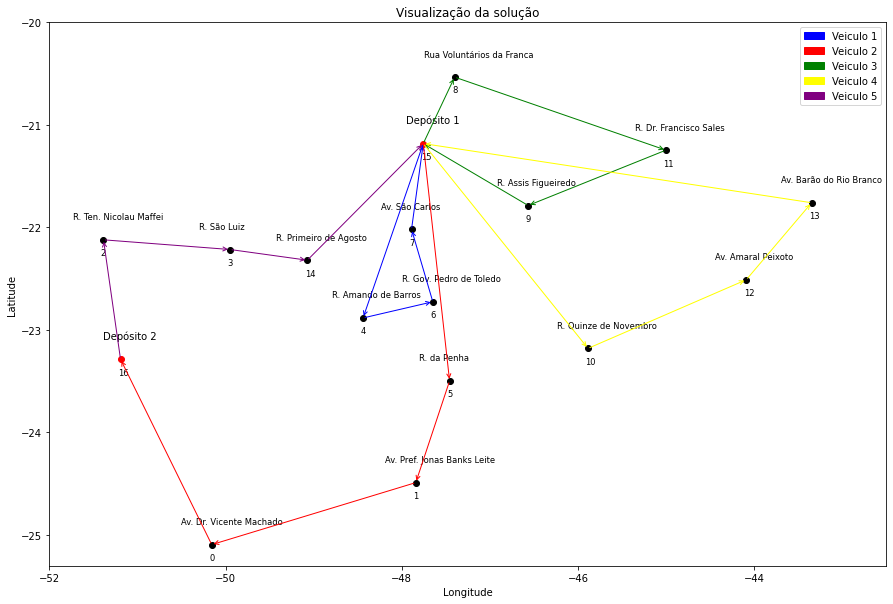

In [ ]:
print("-----------------")
print("Number of vehicles =", 5)
print("Each vehicle can visit a maximum of 3 destinations (L = 3)")
print("-----------------")
print('')

start_t=time.time()

model=pulp.LpProblem('MDVRP',pulp.LpMinimize)

#Variables
x=pulp.LpVariable.dicts("x",((i,j) for i in range(num_cities) \
                             for j in range(num_cities)),\
                            cat='Binary')

#Objective function
model+=pulp.lpSum(matrix[i][j]*x[i,j] for i in range(num_cities) \
                      for j in range(num_cities))

## Restrictions
  
#cannot move from one city to another
for i in range(num_cities):
    model+=x[i,i]==0

#can't go from one deposit to another
model+=x[15,16]==0
model+=x[16,15]==0

# (2) and (3)
for i in range(customer_count):
    model+=pulp.lpSum(x[i,j]  for j in range(num_cities))== 1

for j in range(customer_count):
  model += pulp.lpSum(x[i,j]  for i in range(num_cities)) == 1

# (4) and (5)
model+=pulp.lpSum(x[i,j] for i in range(customer_count , num_cities) for j in range(num_cities))==5

model+=pulp.lpSum(x[i,j] for j in range(customer_count , num_cities) for i in range(num_cities))==5

##Clear sub-routes

#MTZ variables

y = pulp.LpVariable.dicts("y", (i for i in range(customer_count)), \
                             lowBound=1,upBound= customer_count,cat='Integer')


for i in range(customer_count):
    for j in range(customer_count):
        if i!=j:
            model+= y[i]-y[j]+(3)*(x[i,j])<= 3 - 1


status=model.solve()
print("-----------------")
print(pulp.LpStatus[status],'|','FO:',pulp.value(model.objective),'|','Computational time spent:',np.round(time.time()-start_t,4),'s')

route=[(i,j) for i in range(num_cities) \
           for j in range(num_cities) if pulp.value(x[i,j])==1]
print('')

print('Solution:')
for i in range(len(route)):
  print(route[i])

r=copy.copy(route)

sequencia= []
for i,j in r:
  if i==15 or i==16:
    sequencia.append([(i,j)])

for a in sequencia:
  for i,j in r:
    if i == a[0][1]:
      a.append((i,j))

for k in range(1,3):
  for a in sequencia:
    for i,j in r:
      if (a[1][1] != 15)&(a[1][1] != 16):
        if i == a[k][1] :
          a.append((i,j))

print('')
print('Routes:')
print(sequencia)

lista_cores = ['blue', 'red', 'green', 'yellow', 'purple']
patch1 = mpatches.Patch(color='blue', label='Vehicle 1')
patch2 = mpatches.Patch(color='red', label='Vehicle 2')
patch3 = mpatches.Patch(color='green', label='Vehicle 3')
patch4 = mpatches.Patch(color='yellow', label='Vehicle 4')
patch5 = mpatches.Patch(color='purple', label='Vehicle 5')
lista_patchs = [patch1, patch2, patch3, patch4, patch5]


lista3 = []
lista4 = []
for c in range(5):
  lista3.append(lista_cores[c])
  lista4.append(lista_patchs[c])

plot_fig(d,heading="Solution visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')

for cor in range(5):
  for i, j in sequencia[cor]:
      plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                    xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3', edgecolor=lista3[cor]))
plt.legend(handles=lista_patchs)

Defining a fixed number of vehicles for each depot and assuming we have 2 vehicles for each depot

-----------------
Número de veículos =  4
Observação : Com o uso das restrições (9) e (10), é obrigatório que 2 veículos saiam de cada depósito
Cada veículo pode visitar no máximo 4 destinos (L = 4)
-----------------

-----------------
Optimal | FO: 4249.801 | Tempo computacional gasto: 69.6912 s

Soluçao:
(0, 1)
(1, 5)
(2, 3)
(3, 14)
(4, 16)
(5, 4)
(6, 9)
(7, 6)
(8, 15)
(9, 8)
(10, 12)
(11, 15)
(12, 13)
(13, 11)
(14, 16)
(15, 7)
(15, 10)
(16, 0)
(16, 2)

Rotas:
[[(15, 7), (7, 6), (6, 9), (9, 8), (8, 15)], [(15, 10), (10, 12), (12, 13), (13, 11), (11, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 16)], [(16, 2), (2, 3), (3, 14), (14, 16)]]


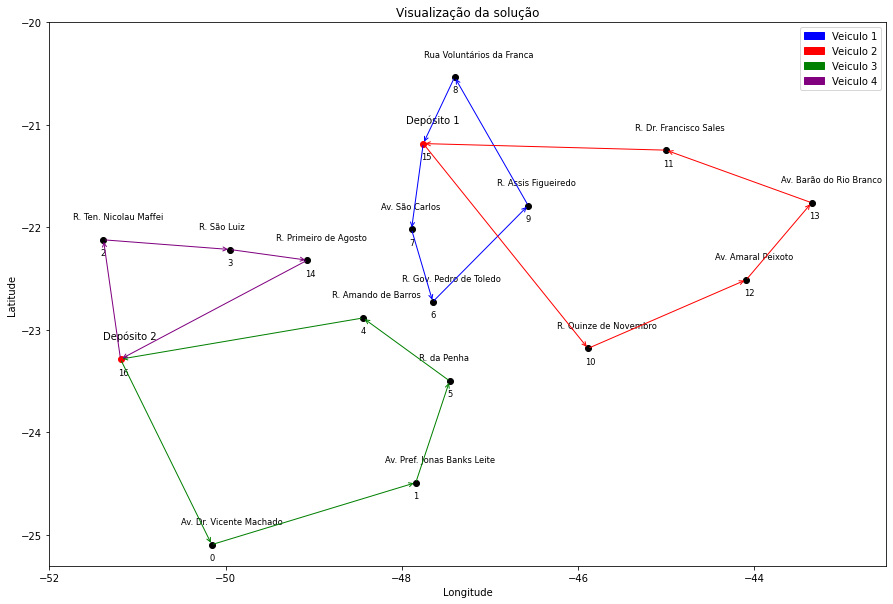

In [ ]:
print("-----------------")
print("Number of vehicles = ", 4)
print("Note: With the use of constraints (9) and (10), it is mandatory that 2 vehicles leave each depot")
print("Each vehicle can visit a maximum of 4 destinations (L = 4)")
print("-----------------")
print("")

start_t=time.time()

model=pulp.LpProblem('MDVRP',pulp.LpMinimize)

#Variables
x=pulp.LpVariable.dicts("x",((i,j) for i in range(num_cities) \
                             for j in range(num_cities)),\
                            cat='Binary')

#Objective function
model+=pulp.lpSum(matrix[i][j]*x[i,j] for i in range(num_cities) \
                      for j in range(num_cities))

## Restrictions

#cannot move from one city to another
for i in range(num_cities):
  model+=x[i,i]==0

#can't go from one deposit to another
model+=x[15,16]==0
model+=x[16,15]==0

# (2) and (3)
for i in range(customer_count):
  model+=pulp.lpSum(x[i,j]  for j in range(num_cities))==1

for j in range(customer_count):
  model+=pulp.lpSum(x[i,j]  for i in range(num_cities))==1

# (9) and (10)
for i in range(customer_count , num_cities):
  model+=pulp.lpSum(x[i,j] for j in range(num_cities))== 2

for j in range(customer_count , num_cities):
  model+=pulp.lpSum(x[i,j] for i in range(num_cities))== 2

##Clear sub-routes

#MTZ variables

y = pulp.LpVariable.dicts("y", (i for i in range(customer_count)), \
                             lowBound=1,upBound= customer_count,cat='Integer')


for i in range(customer_count):
    for j in range(customer_count):
        if i!=j:
            model+= y[i]-y[j]+(4)*(x[i,j])<= 4 - 1

status=model.solve()
print("-----------------")
print(pulp.LpStatus[status],'|','FO:',pulp.value(model.objective),'|','Computational time spent:',np.round(time.time()-start_t,4),'s')

route=[(i,j) for i in range(num_cities) \
           for j in range(num_cities) if pulp.value(x[i,j])==1]
print('')

print('Solution:')
for i in range(len(route)):
  print(route[i])

r=copy.copy(route)

sequencia= []
for i,j in r:
  if i==15 or i==16:
    sequencia.append([(i,j)])

for a in sequencia:
  for i,j in r:
    if i == a[0][1]:
      a.append((i,j))

for k in range(1,3):
  for a in sequencia:
    for i,j in r:
      if (a[1][1] != 15)&(a[1][1] != 16):
        if i == a[k][1] :
          a.append((i,j))

for a in sequencia:
  for i,j in r:
    if (a[1][1] != 15)&(a[1][1] != 16) and (a[3][1] != 15)&(a[3][1] != 16):
      if i == a[3][1] :
        a.append((i,j))

print('')
print('Routes:')
print(sequencia)

lista_cores = ['blue', 'red', 'green','purple']
patch1 = mpatches.Patch(color='blue', label='Vehicle 1')
patch2 = mpatches.Patch(color='red', label='Vehicle 2')
patch3 = mpatches.Patch(color='green', label='Vehicle 3')
patch4 = mpatches.Patch(color='purple', label='Vehicle 4')
lista_patchs = [patch1, patch2, patch3, patch4]

lista3 = []
lista4 = []
for c in range(4):
  lista3.append(lista_cores[c])
  lista4.append(lista_patchs[c])

plot_fig(d,heading="Solution visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')

for cor in range(4):
  for i, j in sequencia[cor]:
      plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                    xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3', edgecolor=lista3[cor]))
plt.legend(handles=lista_patchs)

## **Complementary sensitivity analysis**

Considering new vehicle capacity for the same customer demand

Nova capacidade dos veículos : 16

-----------------
Para 2 veículos :
-----------------
Optimal | FO: 3190.0700000000006 | Tempo computacional gasto: 2.6447 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 2)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 8)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(16, 0)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 2), (2, 16)]]


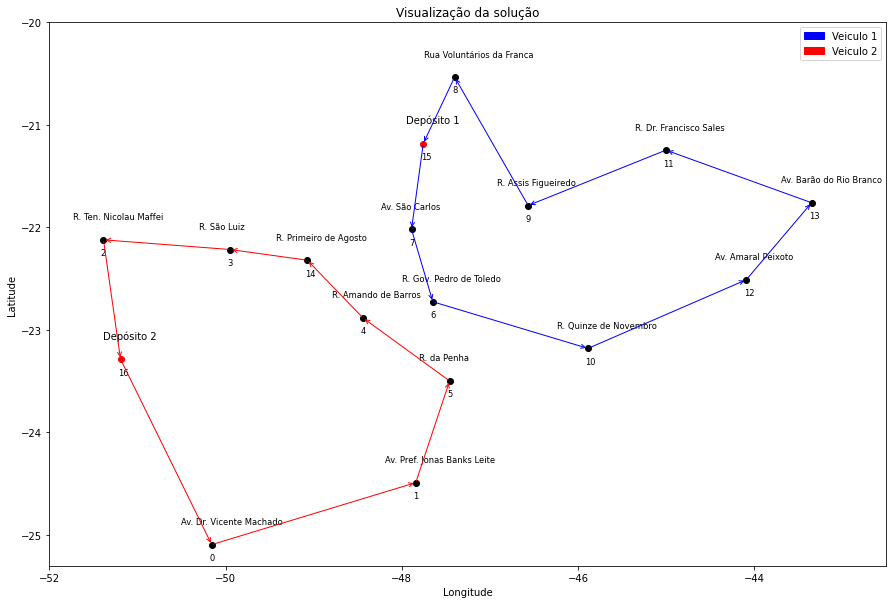


-----------------
Para 3 veículos :
-----------------
Optimal | FO: 3223.344000000001 | Tempo computacional gasto: 1.812 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 2)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(15, 8)
(16, 0)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 15)], [(15, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 2), (2, 16)]]


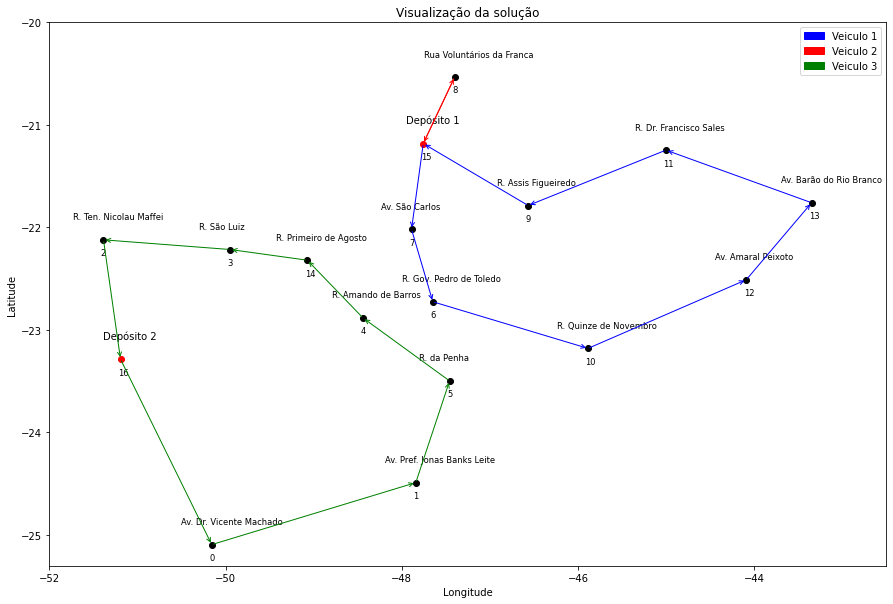


-----------------
Para 4 veículos :
-----------------
Optimal | FO: 3386.440000000001 | Tempo computacional gasto: 1.4608 s

Soluçao:
(0, 1)
(1, 5)
(2, 16)
(3, 16)
(4, 14)
(5, 4)
(6, 10)
(7, 6)
(8, 15)
(9, 15)
(10, 12)
(11, 9)
(12, 13)
(13, 11)
(14, 3)
(15, 7)
(15, 8)
(16, 0)
(16, 2)

Rotas:
[[(15, 7), (7, 6), (6, 10), (10, 12), (12, 13), (13, 11), (11, 9), (9, 15)], [(15, 8), (8, 15)], [(16, 0), (0, 1), (1, 5), (5, 4), (4, 14), (14, 3), (3, 16)], [(16, 2), (2, 16)]]


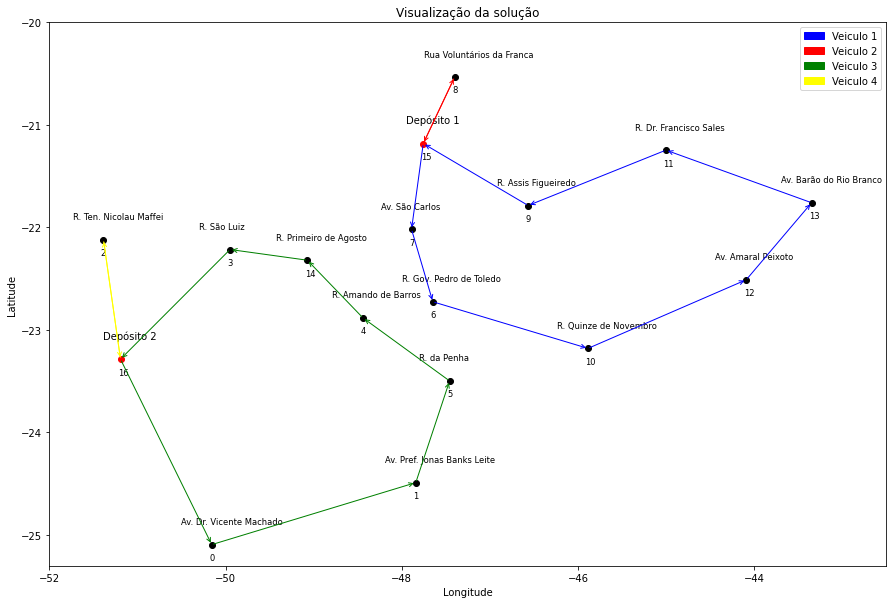

In [ ]:
# Vehicle capacity (considering a homogeneous fleet)
new_vehicle_capacity = 16
print('New vehicle capacity :', new_vehicle_capacity)

numero_veiculos = [2,3,4]
for veiculos in numero_veiculos:

  start_t=time.time()
  print('')
  print("-----------------")
  print('For {} vehicles :'.format(veiculos))

  model=pulp.LpProblem('MDVRP',pulp.LpMinimize)

  #Variables
  x=pulp.LpVariable.dicts("x",((i,j) for i in range(num_cities) \
                             for j in range(num_cities)),\
                            cat='Binary')

  #Objective function
  model+=pulp.lpSum(matrix[i][j]*x[i,j] for i in range(num_cities) \
                      for j in range(num_cities))

  ## Restrictions
  
  #cannot move from one city to another
  for i in range(num_cities):
    model+=x[i,i]==0

  #can't go from one deposit to another
  model+=x[15,16]==0
  model+=x[16,15]==0

  # (2) and (3)
  for i in range(customer_count):
    model+=pulp.lpSum(x[i,j] for j in range(num_cities))==1

  for j in range(customer_count):
    model += pulp.lpSum(x[i,j] for i in range(num_cities)) == 1

  # (4) and (5)
  model+=pulp.lpSum(x[i,j] for i in range(customer_count , num_cities) for j in range(num_cities))==veiculos

  model+=pulp.lpSum(x[i,j] for j in range(customer_count , num_cities) for i in range(num_cities))==veiculos

  ## Clear sub-routes
  
  #MTZ variables

  u = pulp.LpVariable.dicts("u", (i for i in range(customer_count)), \
                             lowBound=1,upBound= customer_count,cat='Integer')

  for i in range(customer_count):
    for j in range(customer_count):
      if i!=j:
        model+= u[i]-u[j]+(new_vehicle_capacity)*(x[i,j])<=new_vehicle_capacity - data_clientes['DEMANDA'][i]


  status=model.solve()
  print("-----------------")
  print(pulp.LpStatus[status],'|','FO:',pulp.value(model.objective),'|','Computational time spent:',np.round(time.time()-start_t,4),'s')

  route=[(i,j) for i in range(num_cities) \
            for j in range(num_cities) if pulp.value(x[i,j])==1]
  print('')

  print('Soluçao:')
  for i in range(len(route)):
    print(route[i])

  r=copy.copy(route)

  sequencia= []
  for i,j in r:
    if i==15 or i==16:
      sequencia.append([(i,j)])

  for a in sequencia:
    for i,j in r:
      if i == a[0][1]:
       a.append((i,j))

  for k in range(1,6):
    for a in sequencia:
      for i,j in r:
        if (a[1][1] != 15)&(a[1][1] != 16):
          if i == a[k][1] :
            a.append((i,j))

  for a in sequencia:
    for i,j in r:
      if (a[1][1] != 15)&(a[1][1] != 16) and (a[6][1] != 15)&(a[6][1] != 16):
        if i == a[6][1] :
          a.append((i,j))

  if veiculos == 2:
    for a in sequencia:
      for i,j in r:
        if (a[1][1] != 15)&(a[1][1] != 16) and (a[7][1] != 15)&(a[7][1] != 16):
          if i == a[7][1] :
            a.append((i,j))

  print('')
  print('Rotas:')
  print(sequencia)
  plot_fig(d,heading="Solution visualization")

  lista_cores = ['blue', 'red', 'green', 'yellow']
  patch1 = mpatches.Patch(color='blue', label='Vehicle 1')
  patch2 = mpatches.Patch(color='red', label='Vehicle 2')
  patch3 = mpatches.Patch(color='green', label='Vehicle 3')
  patch4 = mpatches.Patch(color='yellow', label='Vehicle 4')
  lista_patchs = [patch1, patch2, patch3, patch4]

  lista3 = []
  lista4 = []
  for c in range(veiculos):
    lista3.append(lista_cores[c])
    lista4.append(lista_patchs[c])

  plt.legend(handles=lista4)

  for cor in range(len(lista3)):
    for i, j in sequencia[cor]:
      plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                    xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3', edgecolor=lista3[cor]))
  plt.show()

By reducing the capacity to 16, it can be seen that there was no change in the solutions found. However, by reducing the capacity to 15, the solver spent 2 hours on computation and was unable to find a solution. Therefore, the implementation was interrupted.

Other tests have been carried out, changing the maximum number of vertices that each vehicle can visit. However, the tests are limited to the ratio (number of stores)/(number of vehicles), i.e. in any test in which the number of vehicles multiplied by the maximum number of vertices is less than the number of cities(V*L < N), the model does not reach a conclusion, and continues searching for a solution indefinitely.